In [36]:
import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [37]:
# =========================================================
# 1) TXT 로드 (깨진 줄은 skip) → 기본 전처리
# =========================================================

cols = ["subject", "label", "timestamp", "x", "y", "z"]

df = pd.read_csv(
    "/content/drive/MyDrive/data/WISDM_ar_v1.1_raw.txt",
    header=None,
    names=cols,
    on_bad_lines="skip"   # 깨진 줄은 무시
).dropna()

# z 컬럼 끝 세미콜론 제거 + float 변환
df["z"] = df["z"].astype(str).str.replace(";", "", regex=False).astype(float)

# x, y도 혹시 모르니 float 변환
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)


df

,subject,label,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1086462,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1086463,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1086464,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [38]:
# 타입 캐스팅 + 정렬
df["subject"] = pd.to_numeric(df["subject"], errors="coerce").astype("Int64")
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
for c in ["x","y","z"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().sort_values(["subject","label","timestamp"]).reset_index(drop=True)

print("샘플:\n", df.head(), "\n")
print("고유 subject:", df["subject"].nunique())
print("라벨 분포:", Counter(df["label"]))

샘플:
    subject       label      timestamp     x      y     z
0        1  Downstairs  6552942304000 -0.15   9.15 -0.34
1        1  Downstairs  6552992292000  0.11   9.19  2.76
2        1  Downstairs  6553042310000 -4.06   7.40  4.02
3        1  Downstairs  6553092298000 -2.87   7.93  3.21
4        1  Downstairs  6553142347000 -0.19  10.04  4.82 

고유 subject: 36
라벨 분포: Counter({'Walking': 418393, 'Jogging': 336445, 'Upstairs': 122869, 'Downstairs': 100425, 'Sitting': 59939, 'Standing': 48394})


In [39]:
# =========================================================
# 2) 슬라이딩 윈도우 (WISDM 관례: 200, overlap 50%)
# =========================================================
WINDOW_SIZE = 200
STEP = 100

def create_windows(group_df, window_size=WINDOW_SIZE, step=STEP):
    sig = group_df[["x","y","z"]].values
    label = group_df["label"].iloc[0]
    N = len(sig)
    if N < window_size:
        return np.empty((0, window_size, 3)), np.array([], dtype=object)
    starts = range(0, N - window_size + 1, step)
    Xw = np.stack([sig[s:s+window_size] for s in starts], axis=0)
    yw = np.array([label]*len(Xw), dtype=object)
    return Xw, yw

all_X, all_y, all_subj = [], [], []
for (subj, lbl), g in df.groupby(["subject","label"], sort=False):
    Xw, yw = create_windows(g)
    if len(Xw) > 0:
        all_X.append(Xw); all_y.append(yw); all_subj.extend([subj]*len(Xw))

if not all_X:
    raise ValueError("윈도우가 생성되지 않았어요. WINDOW_SIZE/STEP 또는 데이터 길이를 확인해줘.")

X = np.concatenate(all_X, axis=0)     # (N, T, 3)
y = np.concatenate(all_y, axis=0)
subj_per_win = np.array(all_subj)

print("윈도우 형태:", X.shape)
print("윈도우 라벨 분포:", Counter(y))


윈도우 형태: (10591, 200, 3)
윈도우 라벨 분포: Counter({'Walking': 4128, 'Jogging': 3315, 'Upstairs': 1181, 'Downstairs': 955, 'Sitting': 563, 'Standing': 449})


In [40]:
# =========================================================
# 3) subject-wise split (누수 방지): 70/15/15
# =========================================================
unique_subjects = np.array(sorted(df["subject"].dropna().unique().astype(int)))
rng = np.random.default_rng(42)
rng.shuffle(unique_subjects)

n_total = len(unique_subjects)
n_train = int(0.70 * n_total)
n_val   = int(0.15 * n_total)

train_subjects = unique_subjects[:n_train]
val_subjects   = unique_subjects[n_train:n_train+n_val]
test_subjects  = unique_subjects[n_train+n_val:]

def mask_by_subject(subject_ids):
    return np.isin(subj_per_win, subject_ids)

train_mask = mask_by_subject(train_subjects)
val_mask   = mask_by_subject(val_subjects)
test_mask  = mask_by_subject(test_subjects)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print(f"subjects -> train:{len(train_subjects)}, val:{len(val_subjects)}, test:{len(test_subjects)}")
print("윈도우 개수 ->", X_train.shape, X_val.shape, X_test.shape)

subjects -> train:25, val:5, test:6
윈도우 개수 -> (7459, 200, 3) (1561, 200, 3) (1571, 200, 3)


In [41]:
# =========================================================
# 4) 라벨 인코딩 + 표준화(학습 통계로만 fit)
# =========================================================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
num_classes = len(le.classes_)
print("클래스:", list(le.classes_))

scaler = StandardScaler()
N, T, C = X_train.shape
scaler.fit(X_train.reshape(-1, C))

def scale_3d(X_in):
    Nx, Tx, Cx = X_in.shape
    xf = X_in.reshape(-1, Cx)
    xf = scaler.transform(xf)
    return xf.reshape(Nx, Tx, Cx)

X_train = scale_3d(X_train)
X_val   = scale_3d(X_val)
X_test  = scale_3d(X_test)

클래스: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [42]:
# =========================================================
# 5) tf.data
# =========================================================
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc)).shuffle(8192).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val_enc)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [43]:
# =========================================================
# 6) 1D-CNN 모델
# =========================================================
def build_cnn(input_shape=(WINDOW_SIZE, 3), num_classes=num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 7, padding="same")(inputs); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv1D(128, 5, padding="same")(x);     x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, padding="same")(x);     x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_cnn()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

early = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 200, 64)        │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 200, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,518 (689.52 KB)

 Trainable params: 175,622 (686.02 KB)

 Non-trainable params: 896 (3.50 KB)

In [44]:
# =========================================================
# 7) 학습
# =========================================================
EPOCHS = 100
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.6380 - loss: 1.0350 - val_accuracy: 0.7969 - val_loss: 1.0762
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8655 - loss: 0.3812 - val_accuracy: 0.2793 - val_loss: 1.5118
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9248 - loss: 0.2233 - val_accuracy: 0.1115 - val_loss: 2.1894
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9584 - loss: 0.1408 - val_accuracy: 0.1115 - val_loss: 2.4282
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9772 - loss: 0.0812 - val_accuracy: 0.1377 - val_loss: 2.8604
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9739 - loss: 0.0829 - val_accuracy: 0.2434 - val_loss: 2.5645
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9798 - loss: 0.0647 - val_accuracy: 0.4350 - val_loss: 2.1941
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9857 - loss: 0.0526 - val_accuracy: 


[TEST] loss=0.7523, acc=0.8485

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.35      0.65      0.45        75
     Jogging       0.99      0.91      0.95       606
     Sitting       1.00      0.93      0.96        29
    Standing       0.95      1.00      0.97        36
    Upstairs       0.53      0.81      0.64       132
     Walking       0.93      0.81      0.87       693

    accuracy                           0.85      1571
   macro avg       0.79      0.85      0.81      1571
weighted avg       0.89      0.85      0.86      1571



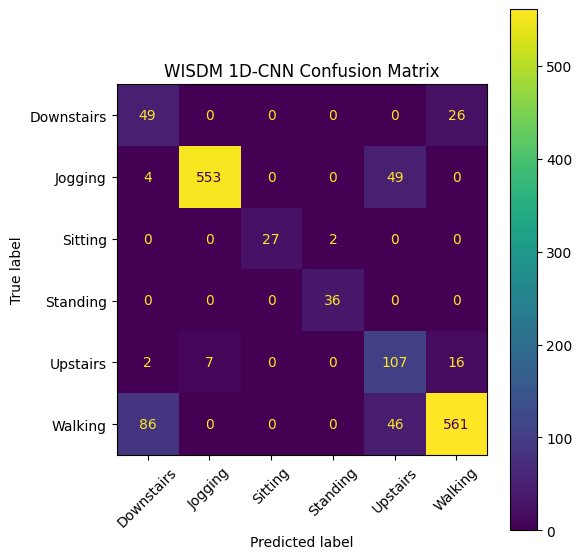

In [45]:
# =========================================================
# 8) 평가 & 리포트
# =========================================================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n[TEST] loss={test_loss:.4f}, acc={test_acc:.4f}")

y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(1)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(ax=ax, xticks_rotation=45)
plt.title("WISDM 1D-CNN Confusion Matrix")
plt.tight_layout()
plt.show()